<a href="https://colab.research.google.com/github/mostafadentist/python-ipynb/blob/main/RNA_seq_Analysis_(Differential_Gene_Expression_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import numpy as np
import pandas as pd

np.random.seed(42)

# 100 genes, 6 samples (3 control, 3 treated)
genes = [f"Gene{i}" for i in range(1,101)]
counts = np.random.poisson(lam=50, size=(100,6))

# Simulate treatment effect for first 10 genes
counts[:10,3:] = np.random.poisson(lam=150, size=(10,3))

df = pd.DataFrame(counts, index=genes, columns=["Ctrl1","Ctrl2","Ctrl3","Treat1","Treat2","Treat3"])
print(df.head())

       Ctrl1  Ctrl2  Ctrl3  Treat1  Treat2  Treat3
Gene1     47     55     42     152     167     144
Gene2     46     49     52     162     162     163
Gene3     52     52     46     151     144     146
Gene4     46     51     64     146     140     139
Gene5     48     58     45     154     154     146


In [112]:
def cpm(counts):
    lib_sizes = counts.sum(axis=0)
    return (counts / lib_sizes) * 1e6

cpm_df = cpm(df)
print(cpm_df.head())

              Ctrl1         Ctrl2         Ctrl3        Treat1        Treat2  \
Gene1   9272.045768  11192.511193   8495.145631  25346.006337  27973.199330   
Gene2   9074.768199   9971.509972  10517.799353  27013.506753  27135.678392   
Gene3  10258.433616  10582.010582   9304.207120  25179.256295  24120.603015   
Gene4   9074.768199  10378.510379  12944.983819  24345.506086  23450.586265   
Gene5   9469.323338  11803.011803   9101.941748  25679.506420  25795.644891   

             Treat3  
Gene1  23841.059603  
Gene2  26986.754967  
Gene3  24172.185430  
Gene4  23013.245033  
Gene5  24172.185430  


In [113]:
from scipy.stats import ttest_ind

results = []
for gene in df.index:
    ctrl = df.loc[gene, ["Ctrl1","Ctrl2","Ctrl3"]]
    treat = df.loc[gene, ["Treat1","Treat2","Treat3"]]
    fold_change = (treat.mean()+1)/(ctrl.mean()+1)  # add 1 to avoid div/0
    stat, pval = ttest_ind(ctrl, treat)
    results.append((gene, fold_change, pval))

res_df = pd.DataFrame(results, columns=["Gene","FoldChange","pval"])
res_df["log2FC"] = np.log2(res_df["FoldChange"])
res_df["-log10p"] = -np.log10(res_df["pval"])
print(res_df.sort_values("pval").head())

    Gene  FoldChange          pval    log2FC   -log10p
1  Gene2    3.266667  3.514396e-07  1.707819  6.454149
2  Gene3    2.901961  4.678880e-06  1.537028  5.329858
5  Gene6    2.745455  2.096064e-05  1.457045  4.678595
4  Gene5    2.967532  2.890666e-05  1.569264  4.539002
3  Gene4    2.609756  1.094730e-04  1.383915  3.960693


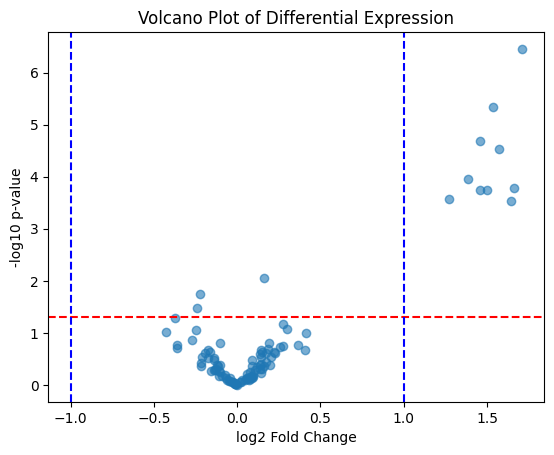

In [114]:
import matplotlib.pyplot as plt

plt.scatter(res_df["log2FC"], res_df["-log10p"], alpha=0.6)
plt.axhline(y=-np.log10(0.05), color="red", linestyle="--")
plt.axvline(x=1, color="blue", linestyle="--")
plt.axvline(x=-1, color="blue", linestyle="--")
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10 p-value")
plt.title("Volcano Plot of Differential Expression")
plt.show()

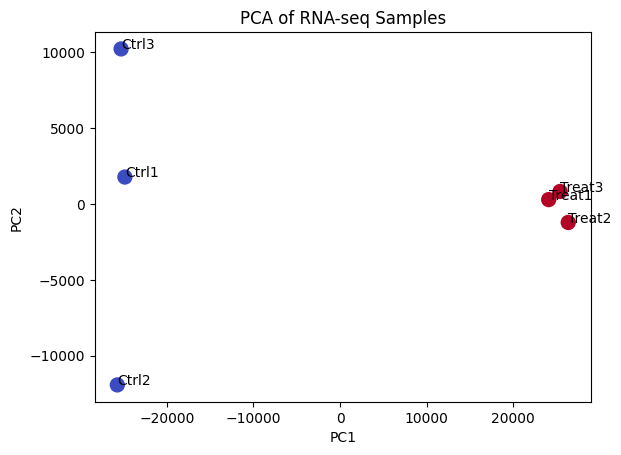

In [115]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = cpm_df.T  # samples as rows
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], c=[0,0,0,1,1,1], cmap="coolwarm", s=100)
for i, sample in enumerate(X.index):
    plt.text(X_pca[i,0]+0.1, X_pca[i,1], sample)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of RNA-seq Samples")
plt.show()

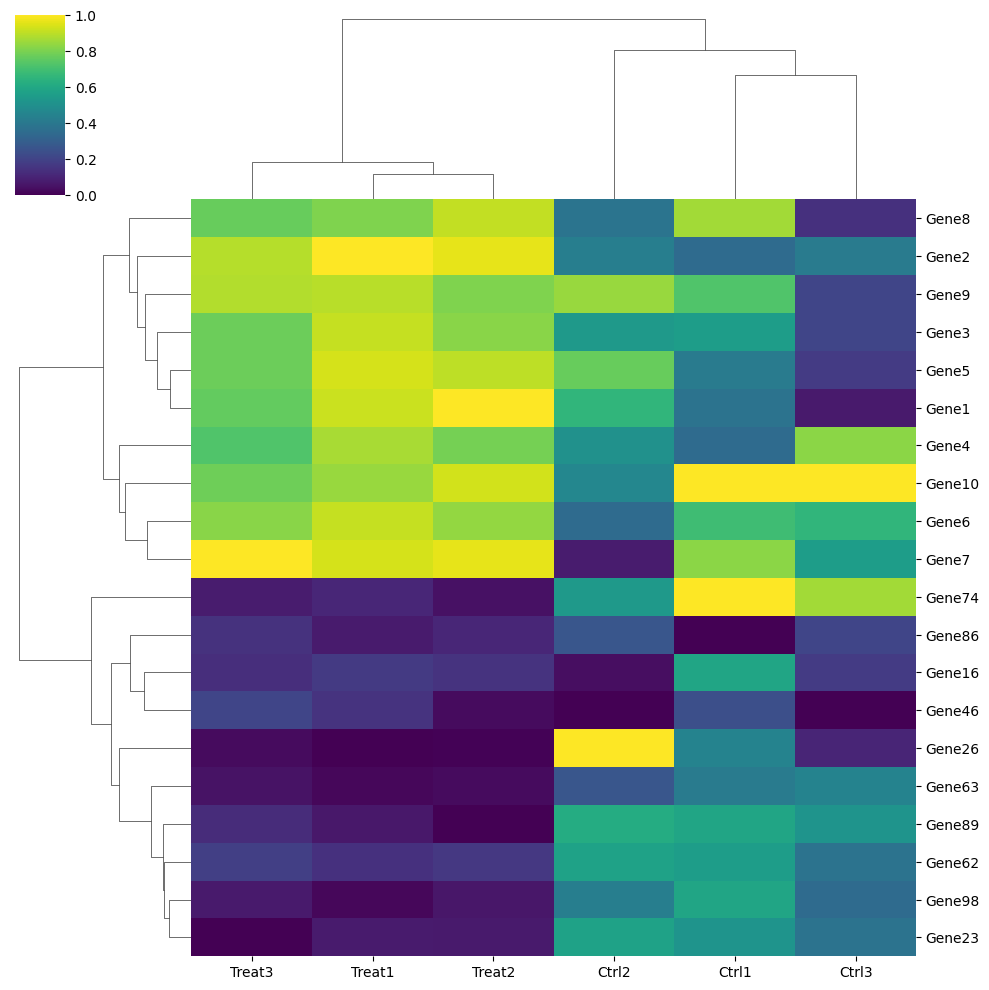

In [116]:
import seaborn as sns

top_genes = res_df.nsmallest(20, "pval")["Gene"]
sns.clustermap(cpm_df.loc[top_genes], cmap="viridis", standard_scale=1)
plt.show()